In [80]:
import torch
from diffusers import UNet2DModel


model = UNet2DModel(
    sample_size=12,  # the target image resolution
    in_channels=16,  # the number of input channels, 3 for RGB images
    out_channels=16,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
    ),
)

In [81]:
sample_image = torch.randn((1, 16, 12, 12))

x = model(sample_image, timestep=0).sample

In [82]:
x.shape

torch.Size([1, 16, 12, 12])

: 

In [138]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape).cuda()
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

In [ ]:
Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).detach().cpu().numpy()[0])

In [146]:
import torch.nn.functional as F

noise_pred = model(noisy_image.cuda(), timesteps.cuda()).sample
loss = F.mse_loss(noise_pred, noise)

In [139]:
noisy_image.shape

torch.Size([1, 64, 4, 4])

In [147]:
loss

tensor(1.0544, device='cuda:0', grad_fn=<MseLossBackward0>)

In [131]:
x.shape

torch.Size([1, 64, 4, 4])

In [1]:
from diffusers import AutoencoderKL, VQModel
import torch

In [2]:
vae = AutoencoderKL(
    in_channels=2,  # the number of input channels, 3 for RGB images
    out_channels=2,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 128, 128),  # the number of output channels for each UNet block
    latent_channels=8,
    down_block_types=(
        "DownEncoderBlock2D",  # a regular ResNet downsampling block
        "DownEncoderBlock2D",
        "DownEncoderBlock2D",
        "DownEncoderBlock2D",
    ),
    up_block_types=(
        "UpDecoderBlock2D",  # a regular ResNet upsampling block
        "UpDecoderBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpDecoderBlock2D",
        "UpDecoderBlock2D",
    ),    
).cuda()

In [4]:
vae = VQModel(
            in_channels=2,  # the number of input channels, 3 for RGB images
            out_channels=2,  # the number of output channels
            layers_per_block=2,  # how many ResNet layers to use per UNet block
            block_out_channels=(128, 128, 128, 128),  # the number of output channels for each UNet block
            latent_channels=16,
            down_block_types=(
                "DownEncoderBlock2D",  # a regular ResNet downsampling block
                "DownEncoderBlock2D",
                "DownEncoderBlock2D",
                "DownEncoderBlock2D",
            ),
            up_block_types=(
                "UpDecoderBlock2D",  # a regular ResNet upsampling block
                "UpDecoderBlock2D",  # a ResNet upsampling block with spatial self-attention
                "UpDecoderBlock2D",
                "UpDecoderBlock2D",
            ),    
        ).cuda()

In [5]:
input = torch.randn((1, 2, 96, 96)).cuda()
enc = vae.encode(input)

In [9]:
enc.latents.shape

torch.Size([1, 16, 12, 12])

In [6]:
mu, logvar = enc.latent_dist.mean, enc.latent_dist.logvar

AttributeError: 'VQEncoderOutput' object has no attribute 'latent_dist'

In [36]:
# Reparameterization trick
std = torch.exp(logvar / 2)
eps = torch.randn_like(std)
z = mu + eps * std

In [10]:
z = enc.latents

In [14]:
quant, emb_loss, info = vae.quantize(z)
quant = vae.post_quant_conv(quant)
dec = vae.decoder(quant)

In [15]:
emb_loss

tensor(0.0537, device='cuda:0', grad_fn=<AddBackward0>)

: 

In [11]:
reconstructed = vae.decode(z).sample

In [12]:
reconstructed.shape

torch.Size([1, 2, 96, 96])

In [40]:
from torch import nn

In [42]:
recon_loss = nn.MSELoss()(reconstructed, input)

In [43]:
kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

In [44]:
kl_divergence

tensor(78.1524, device='cuda:0', grad_fn=<MulBackward0>)

In [45]:
from torchvision.ops import MLP

In [47]:
mu.shape

torch.Size([1, 8, 12, 12])

In [51]:
in_channels = mu[0].numel()

In [52]:
in_channels

1152

In [68]:
out_channels = 1049

In [69]:
mlp = MLP(in_channels, [in_channels*4, out_channels], dropout=0.2)
mlp.cuda()

MLP(
  (0): Linear(in_features=1152, out_features=4608, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=4608, out_features=1049, bias=True)
  (4): Dropout(p=0.2, inplace=True)
)

In [70]:
mlp

MLP(
  (0): Linear(in_features=1152, out_features=4608, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=4608, out_features=1049, bias=True)
  (4): Dropout(p=0.2, inplace=True)
)

In [71]:
X = mlp(mu.reshape(mu.shape[0], -1))

In [72]:
X.shape

torch.Size([1, 1049])

In [73]:
ce = nn.CrossEntropyLoss()

In [78]:
ce(X, torch.asarray([1]).cuda())

tensor(6.9586, device='cuda:0', grad_fn=<NllLossBackward0>)

In [23]:
x.sample.shape

torch.Size([1, 2, 96, 96])

In [ ]:
#small MLP?????

In [54]:
100 * 100 * 2

20000

In [56]:
4 * 16 * 16

1024

In [44]:
64 * 4 * 4

1024

In [1]:
from diffusers import AutoencoderKL

/opt/conda/envs/pytorch/lib/python3.9/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [48]:
4*("DownEncoderBlock2D",)

('DownEncoderBlock2D',
 'DownEncoderBlock2D',
 'DownEncoderBlock2D',
 'DownEncoderBlock2D')

In [62]:
model = VQModel(in_channels=2, out_channels=2, down_block_types=2*("DownEncoderBlock2D",),
                up_block_types=2*("UpDecoderBlock2D",), block_out_channels=2*(64,))
# model = AutoencoderKL(in_channels=2, out_channels=2)
model.cuda()

VQModel(
  (encoder): Encoder(
    (conv_in): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
            (conv1): Conv2d(64, 64, 

In [52]:
import torch

input_image = torch.randn((10, 2, 100, 100)).cuda()

In [63]:
output_image = model(input_image)

In [64]:
output_image.sample.shape

torch.Size([10, 2, 100, 100])

In [ ]:
model.encode

In [65]:
a = model.encode(input_image)

In [66]:
a.latents.shape

torch.Size([10, 3, 50, 50])

In [61]:
100 / 2 / 2

25.0

In [2]:
from diffusers import StableDiffusionPipeline

/opt/conda/envs/pytorch/lib/python3.9/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [16]:
import math
from functools import partial
from torch.optim.lr_scheduler import LambdaLR
from torch.optim.optimizer import Optimizer


def _get_cosine_schedule_with_warmup_lr_lambda(
    current_step: int, *, num_warmup_steps: int, num_training_steps: int, num_cycles: float, min_value: float
):
    if current_step < num_warmup_steps:
        return float(current_step) / float(max(1, num_warmup_steps))
    
    progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
    
    # Amplitude of cosine wave should be half the difference between 1 and min_value
    amplitude = (1.0 - min_value) / 2.0

    # Offset cosine decay to shift from [1, min_value]
    cosine_decay = amplitude * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)) + amplitude + min_value - 0.5
    
    return cosine_decay

In [23]:
a = [_get_cosine_schedule_with_warmup_lr_lambda(
    current_step = cs,
    num_warmup_steps = 100,
    num_training_steps = 15_000,
    num_cycles=0.5,
    min_value=0.1,
) for cs in range(20_000)]

In [3]:
import matplotlib.pyplot as plt

In [22]:
import math

def _get_cosine_schedule_with_warmup_lr_lambda(
    current_step: int, *, num_warmup_steps: int, num_training_steps: int, num_cycles: float, min_value: float
):
    if current_step < num_warmup_steps:
        return float(current_step) / float(max(1, num_warmup_steps))

    if current_step > num_training_steps:
        return min_value

    progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

    # Cosine decay from 1.0 to min_value
    cosine_decay = (1.0 + math.cos(math.pi * progress)) / 2.0 * (1.0 - min_value) + min_value

    return cosine_decay


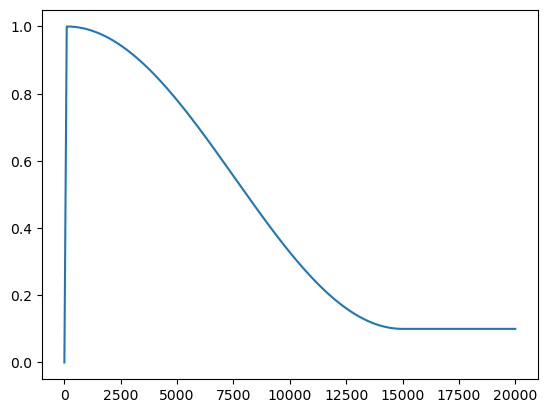

In [24]:
plt.plot(a);